In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [8]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [9]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [10]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [11]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [12]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [13]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [14]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [15]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [16]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [17]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [18]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [19]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [20]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,10,0.008727,0.034905,16.5,4.0
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,10,0.008727,0.034905,16.5,4.0
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,10,0.008727,0.034905,16.5,4.0
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,10,0.008727,0.034905,16.5,4.0
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,10,0.008727,0.034905,16.5,4.0
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,10,0.008727,0.034905,16.5,4.0
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,10,0.008727,0.034905,16.5,4.0
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [21]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [22]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [23]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [24]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :    12.00  :   0.00 :  1794.39 :  7200.00
Mean     :    12.00  :   0.00 :  1794.39 :  7200.00
Median   :    11.90  :   0.00 :  1792.82 :  7200.00
GeoMean  :    11.97  :   0.00 :  1794.38 :  7200.99
Min      :    10.50  :   0.00 :  1792.82 :  7200.00
Max      :    15.20  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


## Automated Training with Sieve Method


********************************************************************************
Round 1: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 3200 samples
Epoch 1/4
3200/3200 [==============================] - 4s 1ms/sample - loss: -610506.2762
Epoch 2/4
3200/3200 [==============================] - 2s 488us/sample - loss: -660424.3600
Epoch 3/4
3200/3200 [==============================] - 1s 466us/sample - loss: -715197.8962
Epoch 4/4
3200/3200 [==============================] - 2s 472us/sample - loss: -775429.8675
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1355.95 :  1355.95 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     16.51 :    16.51 :      nan
Mean Hits           :      0.

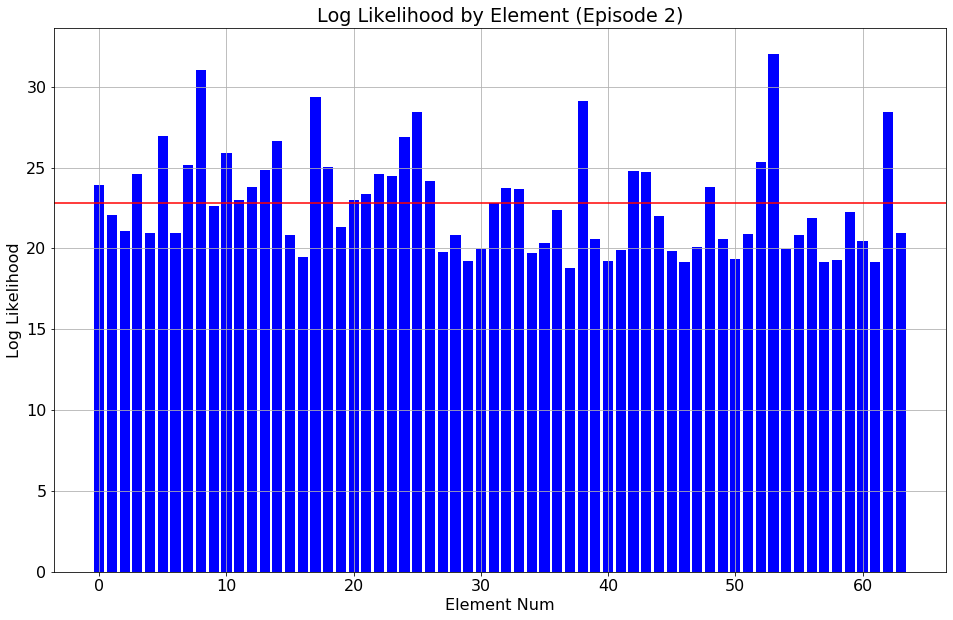

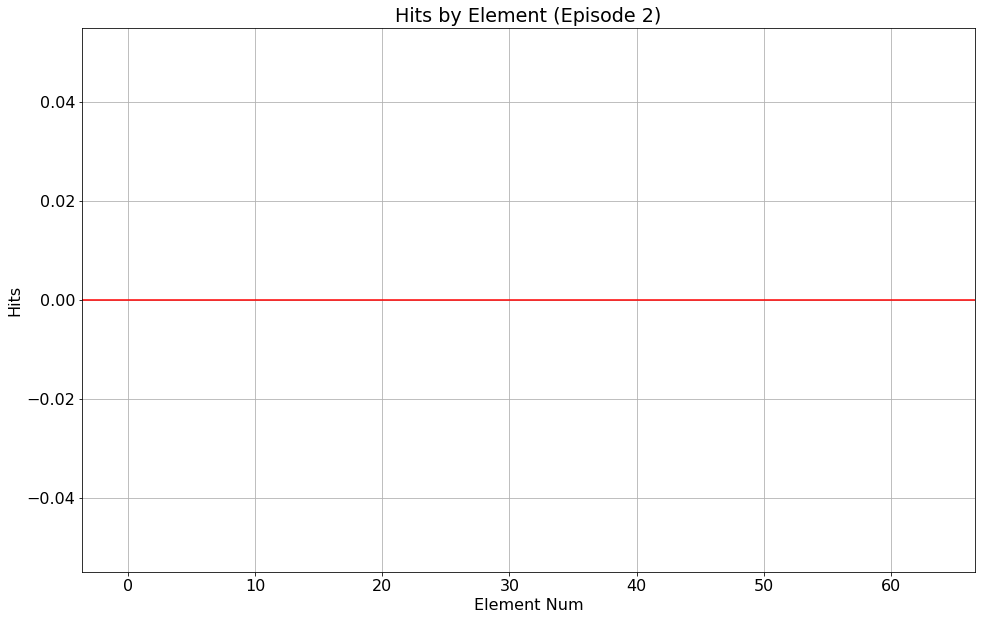


********************************************************************************
Round 2: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    400
effective_learning_rate=1.526e-05, training_time 23 sec.
Train on 3200 samples
Epoch 9/12
3200/3200 [==============================] - 5s 1ms/sample - loss: -1410589.2775
Epoch 10/12
3200/3200 [==============================] - 2s 628us/sample - loss: -1534270.5475
Epoch 11/12
3200/3200 [==============================] - 2s 597us/sample - loss: -1606510.0675
Epoch 12/12
3200/3200 [==============================] - 2s 621us/sample - loss: -1672726.8050
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1106.70 :  1106.70 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :     34.

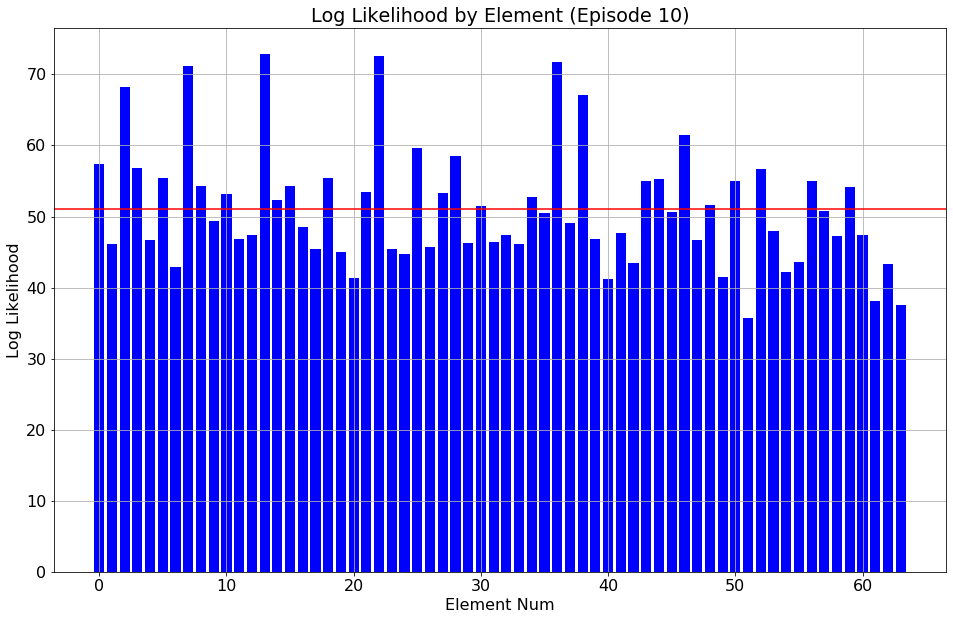

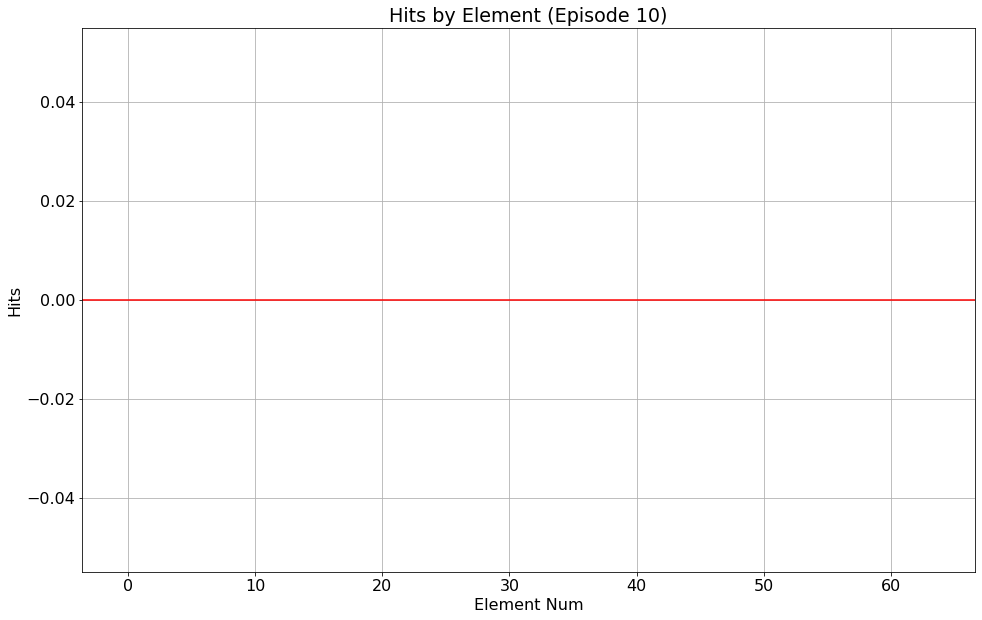


********************************************************************************
Round 3: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2000
effective_learning_rate=1.526e-05, training_time 104 sec.
Train on 3200 samples
Epoch 41/44
3200/3200 [==============================] - 4s 1ms/sample - loss: -3562707.6050
Epoch 42/44
3200/3200 [==============================] - 2s 579us/sample - loss: -3889527.5000
Epoch 43/44
3200/3200 [==============================] - 2s 575us/sample - loss: -4225250.4450
Epoch 44/44
3200/3200 [==============================] - 2s 500us/sample - loss: -4566367.4500
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    661.21 :   661.21 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      nan arc seconds
Mean Log Likelihood :     54.97 :    54.97 :      nan
Mean Hits     

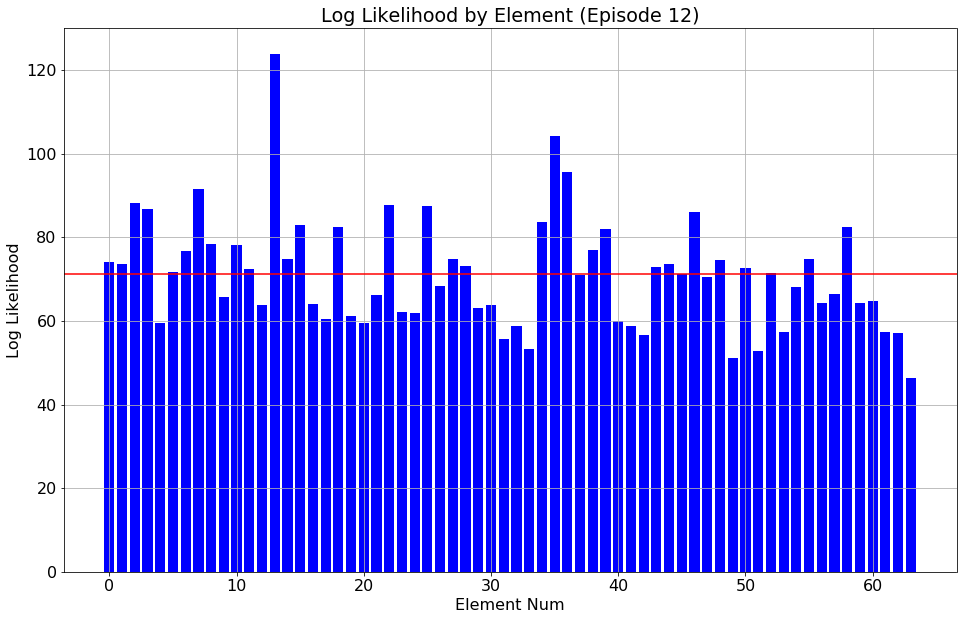

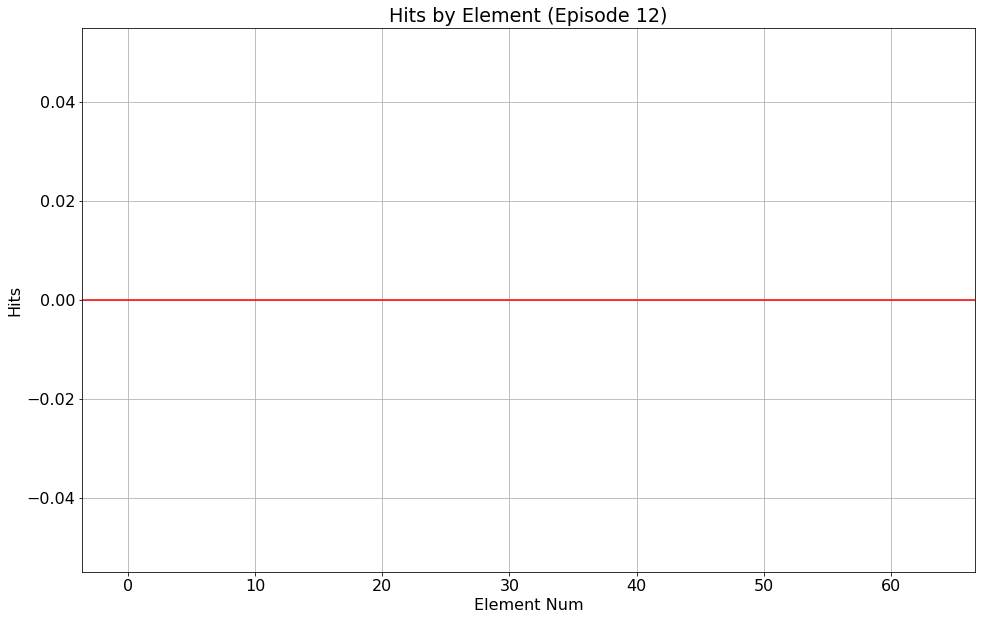


********************************************************************************
Round 4: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   2400
effective_learning_rate=1.526e-05, training_time 123 sec.
Train on 3200 samples
Epoch 49/52
3200/3200 [==============================] - 5s 2ms/sample - loss: -6261189.1300
Epoch 50/52
3200/3200 [==============================] - 2s 706us/sample - loss: -6359393.8600
Epoch 51/52
3200/3200 [==============================] - 2s 649us/sample - loss: -6433178.2400
Epoch 52/52
3200/3200 [==============================] - 2s 650us/sample - loss: -6504575.3900
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    583.68 :   583.68 :      nan arc seconds
Geom Mean Threshold :   5397.76 :  5397.76 :      nan arc seconds
Mean Log Likelihood :     

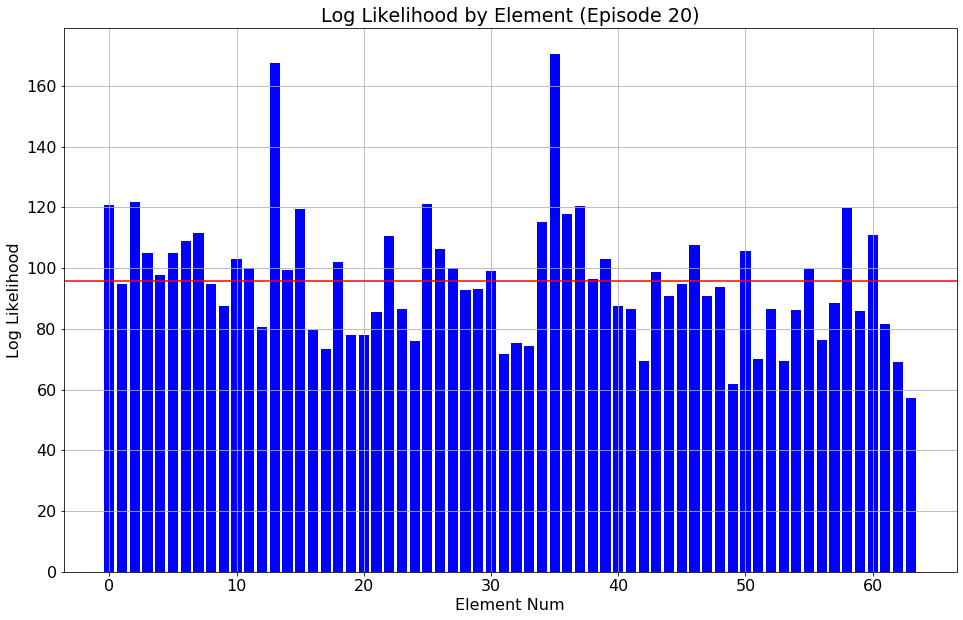

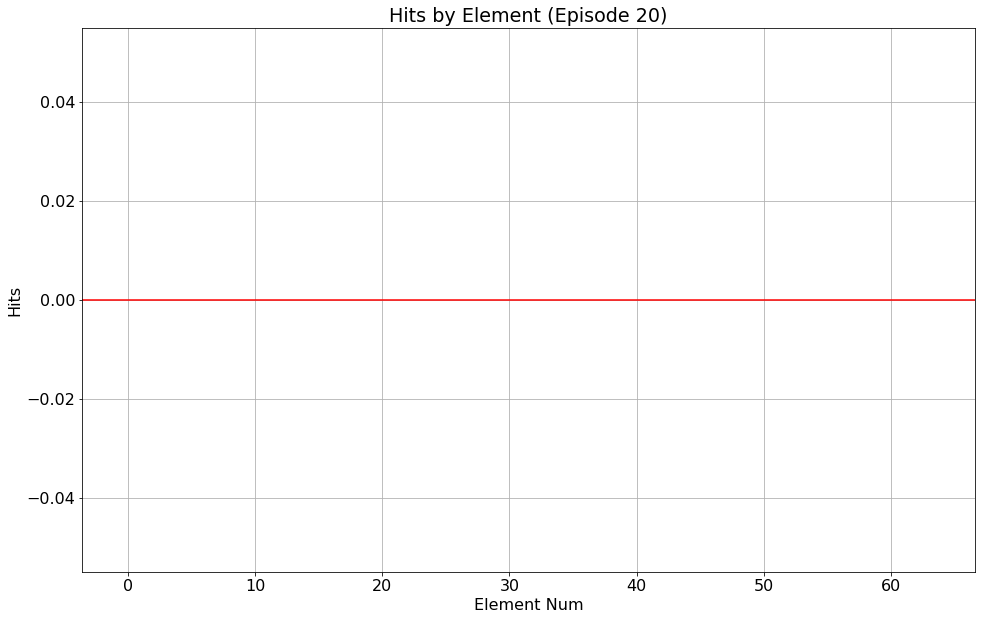


********************************************************************************
Round 5: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   4000
effective_learning_rate=1.526e-05, training_time 208 sec.
Train on 3200 samples
Epoch 81/84
3200/3200 [==============================] - 4s 1ms/sample - loss: -16955035.3600
Epoch 82/84
3200/3200 [==============================] - 2s 549us/sample - loss: -18402470.9600
Epoch 83/84
3200/3200 [==============================] - 2s 549us/sample - loss: -20055379.2400
Epoch 84/84
3200/3200 [==============================] - 2s 575us/sample - loss: -21823088.3600
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    489.20 :   489.20 :      nan arc seconds
Geom Mean Threshold :   3451.66 :  3451.66 :      nan arc seconds
Mean Log Likelihood :    102.49 :   102.49 :      nan
Mean Hits 

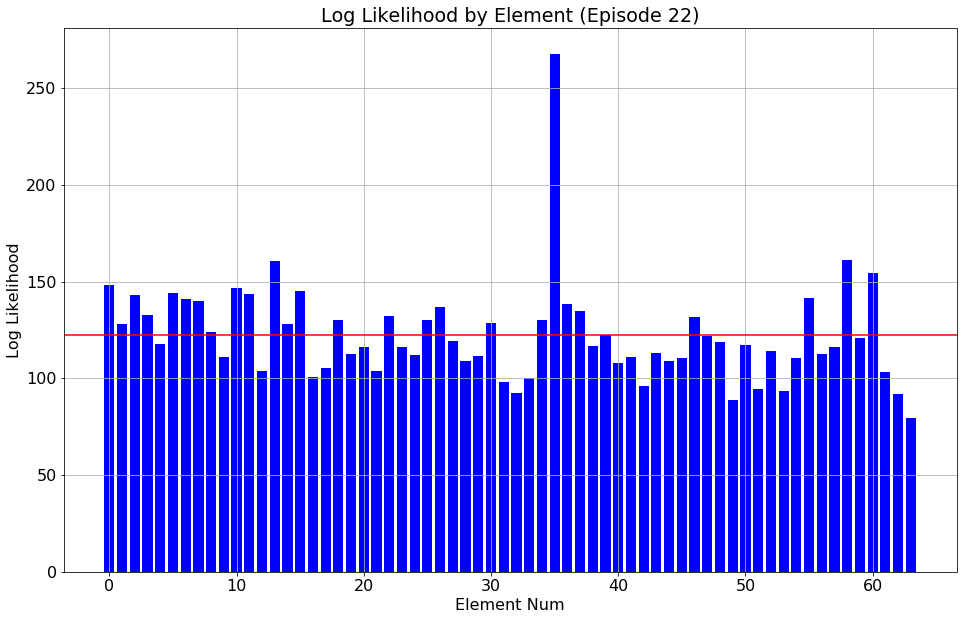

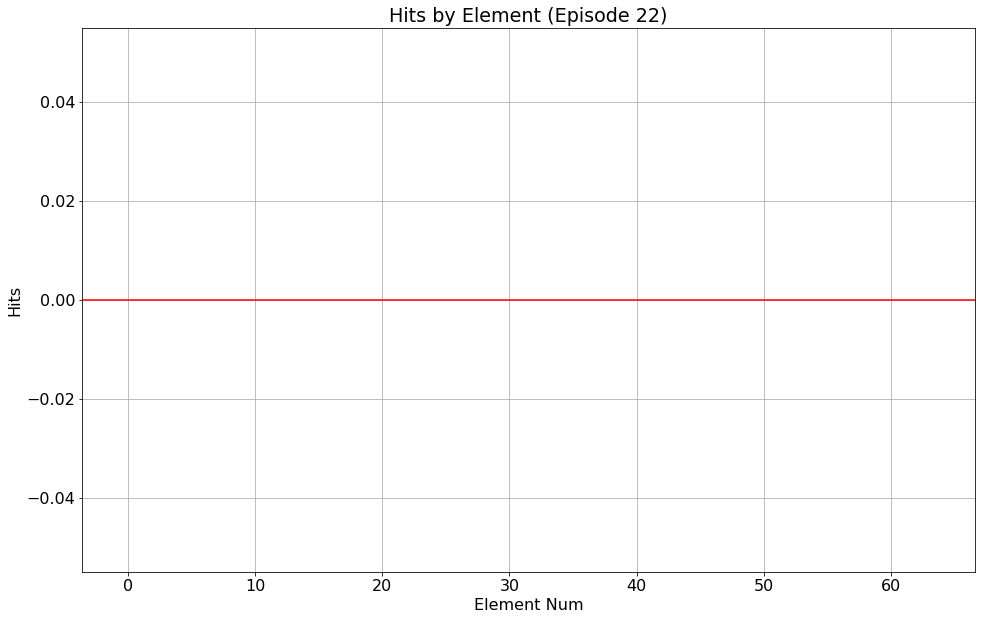


********************************************************************************
Round 6: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   4400
effective_learning_rate=2.403e-04, training_time 227 sec.
Train on 3200 samples
Epoch 89/92
3200/3200 [==============================] - 5s 1ms/sample - loss: -30977186.7200
Epoch 90/92
3200/3200 [==============================] - 2s 705us/sample - loss: -31369346.2400
Epoch 91/92
3200/3200 [==============================] - 2s 694us/sample - loss: -31655560.6400
Epoch 92/92
3200/3200 [==============================] - 2s 722us/sample - loss: -31937582.1200
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    559.24 :   559.24 :      nan arc seconds
Geom Mean Threshold :   3407.34 :  3407.34 :      nan arc seconds
Mean Log Likelihood : 

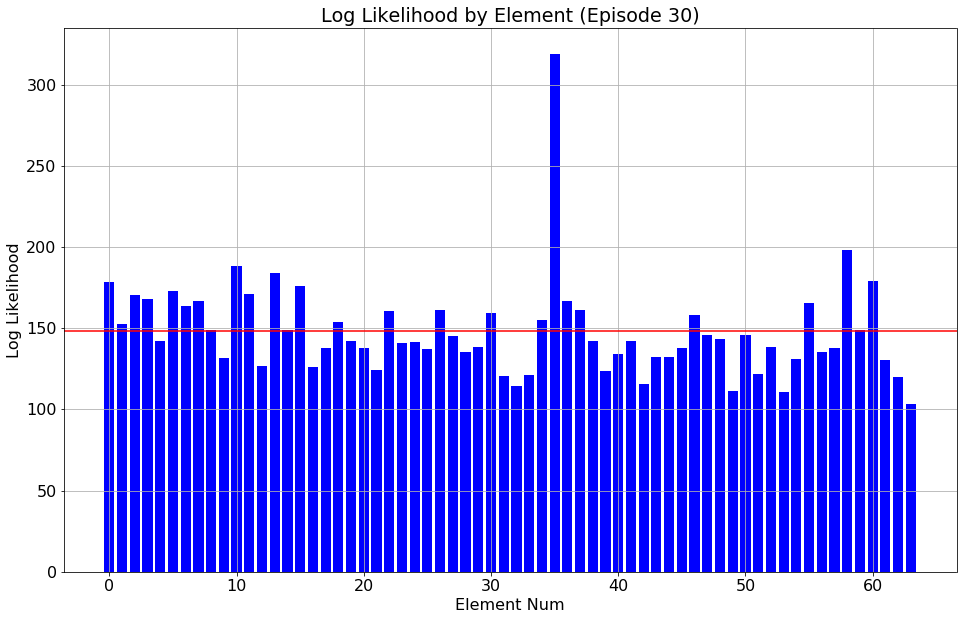

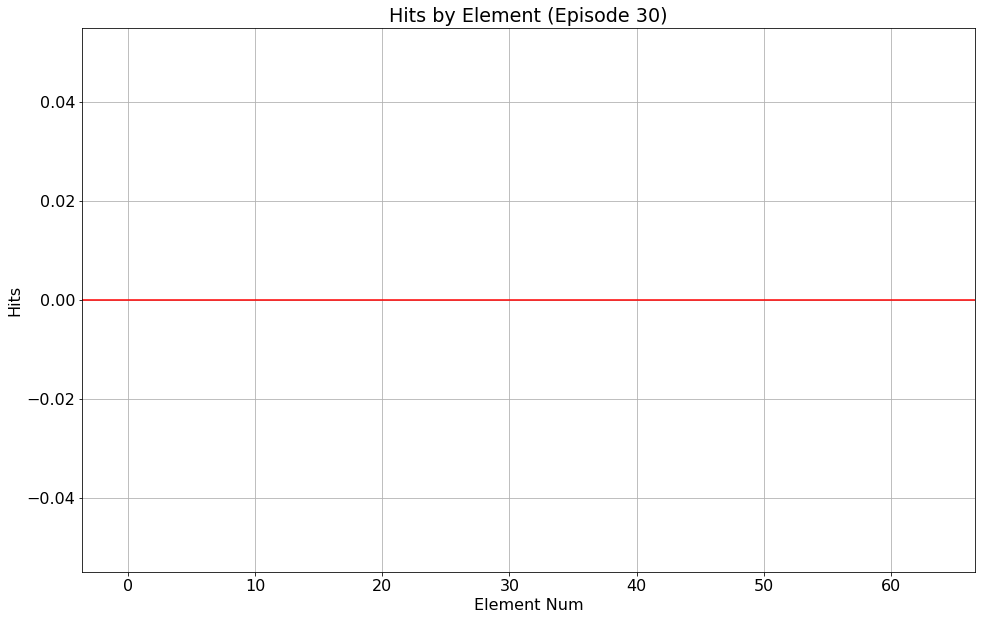


********************************************************************************
Round 7: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3000.0
********************************************************************************

Training episode 30: Epoch  120, Batch   6000
effective_learning_rate=2.441e-04, training_time 314 sec.
Train on 3200 samples
Epoch 121/124
3200/3200 [==============================] - 4s 1ms/sample - loss: -52231271.3600
Epoch 122/124
3200/3200 [==============================] - 2s 578us/sample - loss: -56839708.5600
Epoch 123/124
3200/3200 [==============================] - 2s 566us/sample - loss: -62465542.8000
Epoch 124/124
3200/3200 [==============================] - 2s 607us/sample - loss: -68993262.4800
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    711.16 :   711.16 :      nan arc seconds
Geom Mean Threshold :   2820.59 :  2820.59 :      nan arc seconds
Mean Log Likelihood :    171.70 :   171.70 :      nan
Me

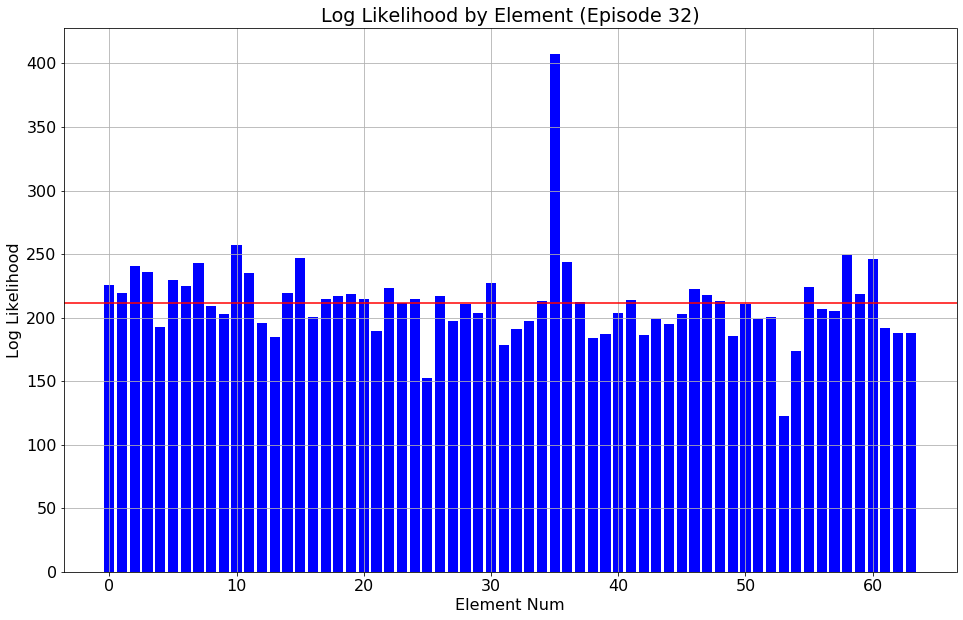

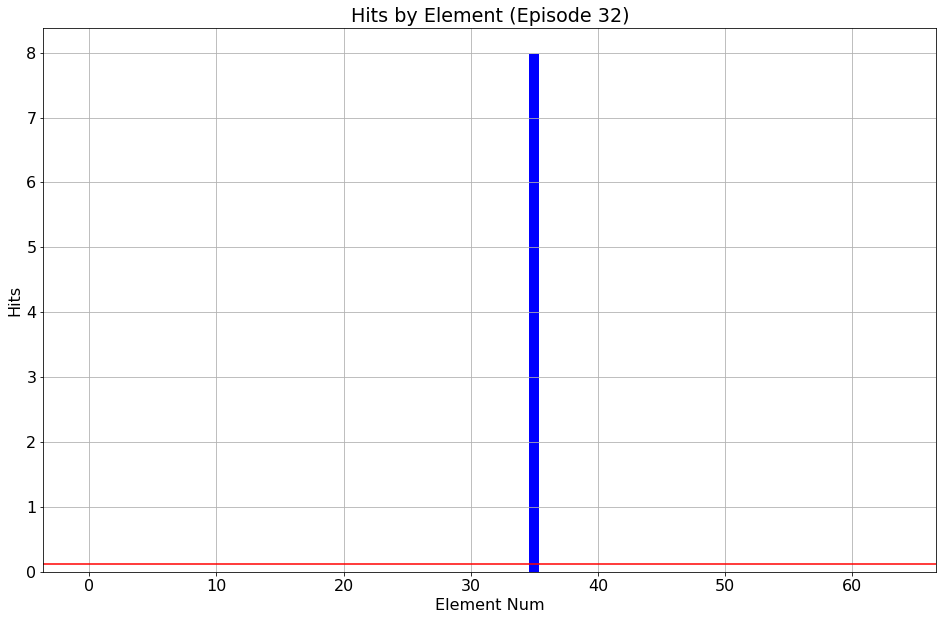


********************************************************************************
Round 8: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 32: Epoch  128, Batch   6400
effective_learning_rate=1.526e-05, training_time 335 sec.
Train on 3200 samples
Epoch 129/132
3200/3200 [==============================] - 5s 2ms/sample - loss: -114260122.5600
Epoch 130/132
3200/3200 [==============================] - 2s 719us/sample - loss: -118382948.9600
Epoch 131/132
3200/3200 [==============================] - 2s 732us/sample - loss: -119383736.0000
Epoch 132/132
3200/3200 [==============================] - 2s 749us/sample - loss: -120386676.3200
Adjusted element weight down on 3 candidate elements. Mean weight = 9.77e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    909.91 :   956.64 :    38.79 arc seconds

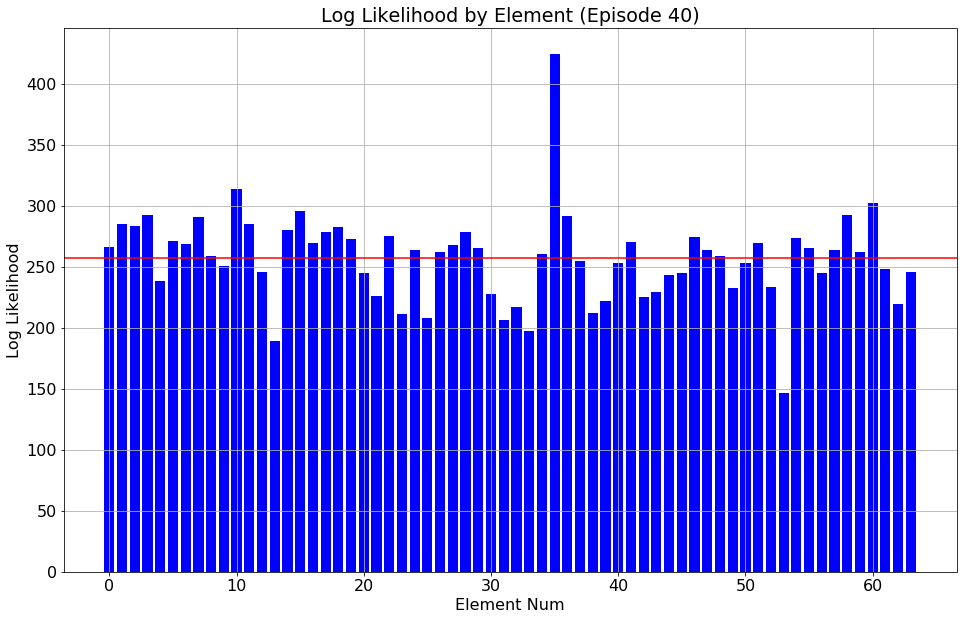

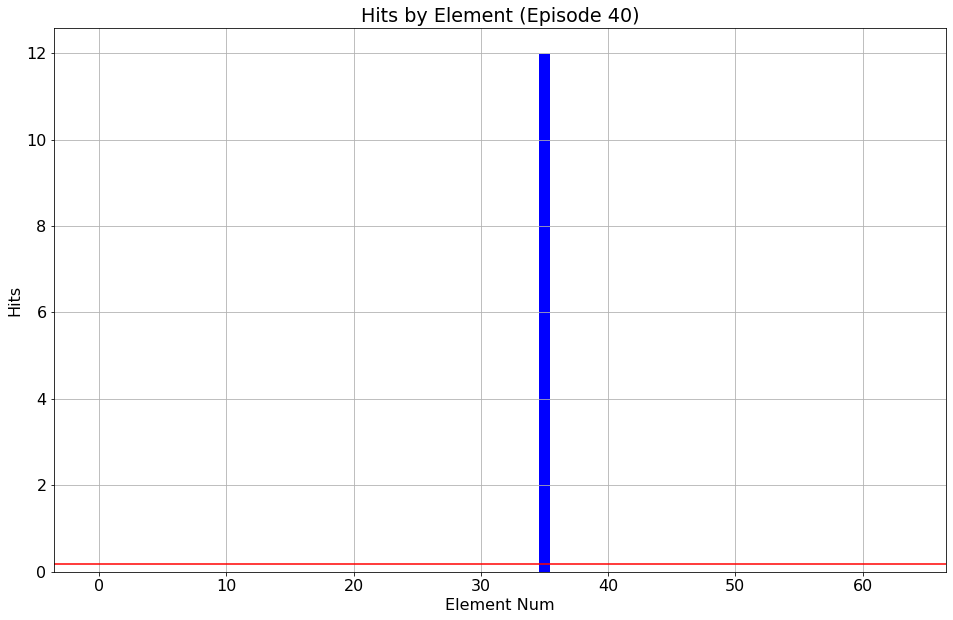


********************************************************************************
Round 9: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 40: Epoch  160, Batch   8000
effective_learning_rate=1.372e-05, training_time 426 sec.
Train on 3200 samples
Epoch 161/164
3200/3200 [==============================] - 4s 1ms/sample - loss: -186239068.4800
Epoch 162/164
3200/3200 [==============================] - 2s 625us/sample - loss: -212645977.9200
Epoch 163/164
3200/3200 [==============================] - 2s 621us/sample - loss: -247282642.8800
Epoch 164/164
3200/3200 [==============================] - 2s 649us/sample - loss: -292381032.3200
Adjusted element weight down on 4 candidate elements. Mean weight = 9.57e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:   1006.09 :  1061.34 :    34.65 arc seconds
Geom Mean Threshold :   1868.43 :  1909.3

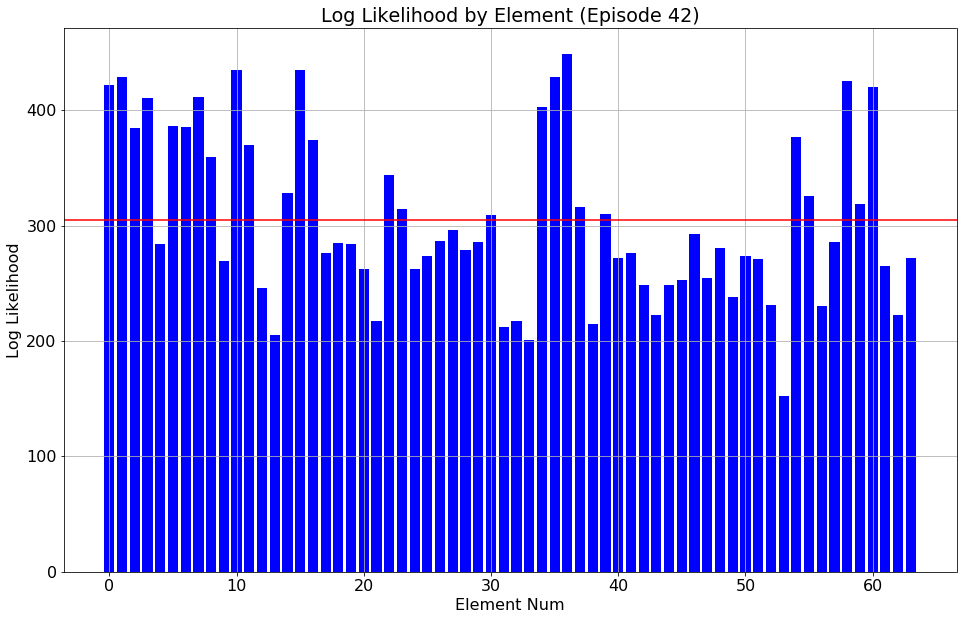

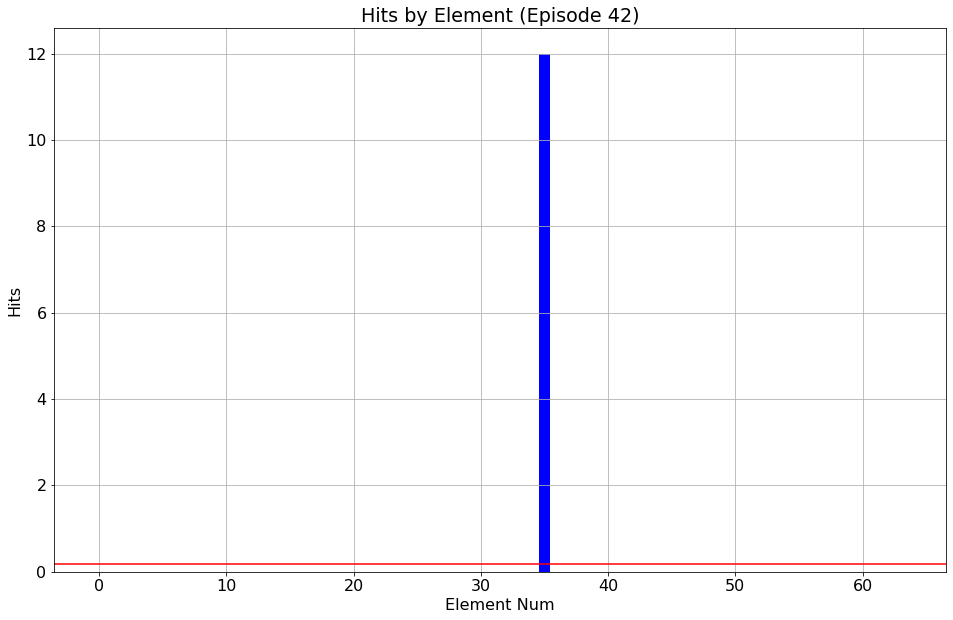


********************************************************************************
Round 10: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 42: Epoch  168, Batch   8400
effective_learning_rate=1.707e-04, training_time 448 sec.
Train on 3200 samples
Epoch 169/172
3200/3200 [==============================] - 5s 2ms/sample - loss: -241609378.8800
Epoch 170/172
3200/3200 [==============================] - 3s 792us/sample - loss: -248909532.8000
Epoch 171/172
3200/3200 [==============================] - 2s 733us/sample - loss: -251767777.9200
Epoch 172/172
3200/3200 [==============================] - 2s 757us/sample - loss: -254582724.4800
Adjusted element weight down on 5 candidate elements. Mean weight = 8.73e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:   1036.66 :  1097.85 :    27.95 arc second

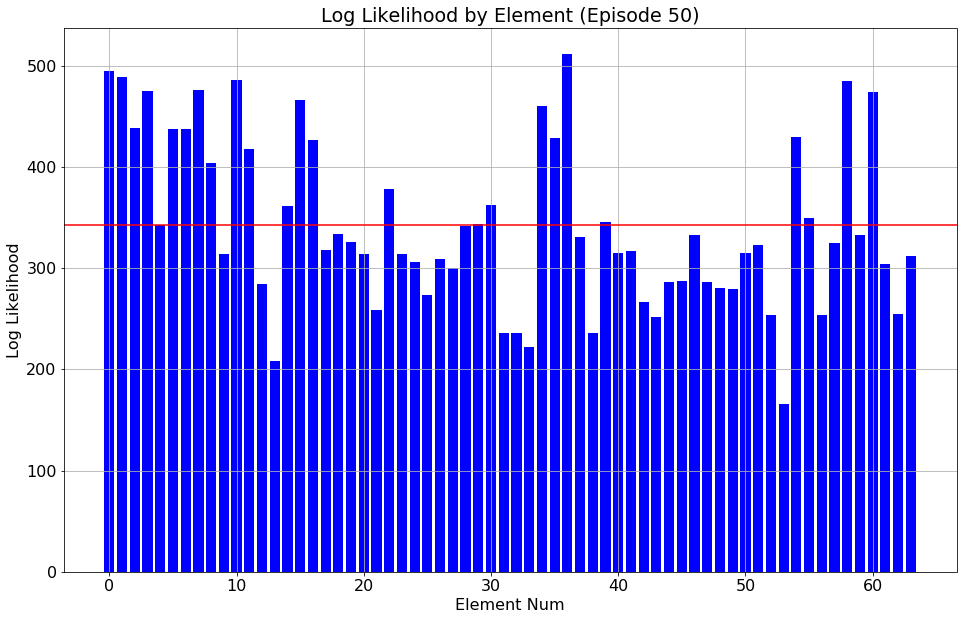

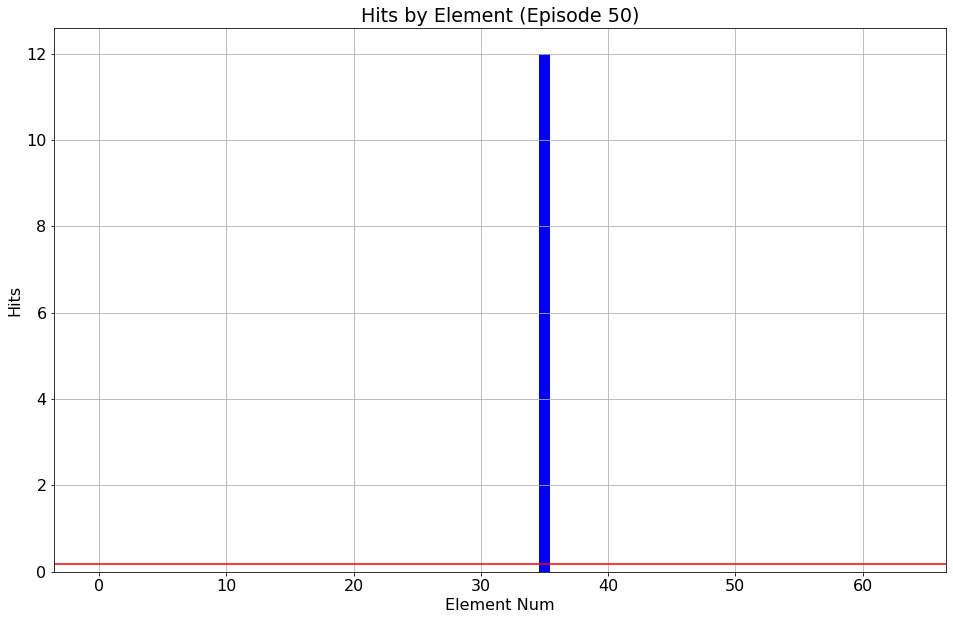


********************************************************************************
Round 11: 400 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 1800.0
********************************************************************************

Training episode 50: Epoch  200, Batch  10000
effective_learning_rate=1.202e-05, training_time 541 sec.
Train on 3200 samples
Epoch 201/204
3200/3200 [==============================] - 4s 1ms/sample - loss: -358581131.5200
Epoch 202/204
3200/3200 [==============================] - 2s 672us/sample - loss: -404420957.4400
Epoch 203/204
3200/3200 [==============================] - 2s 628us/sample - loss: -456869756.8000
Epoch 204/204
3200/3200 [==============================] - 2s 659us/sample - loss: -515308619.5200
Adjusted element weight down on 43 candidate elements. Mean weight = 4.94e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    828.05 :   873.81 :    27.95 arc seconds
Geom Mean Threshold :   1276.34 :  1299

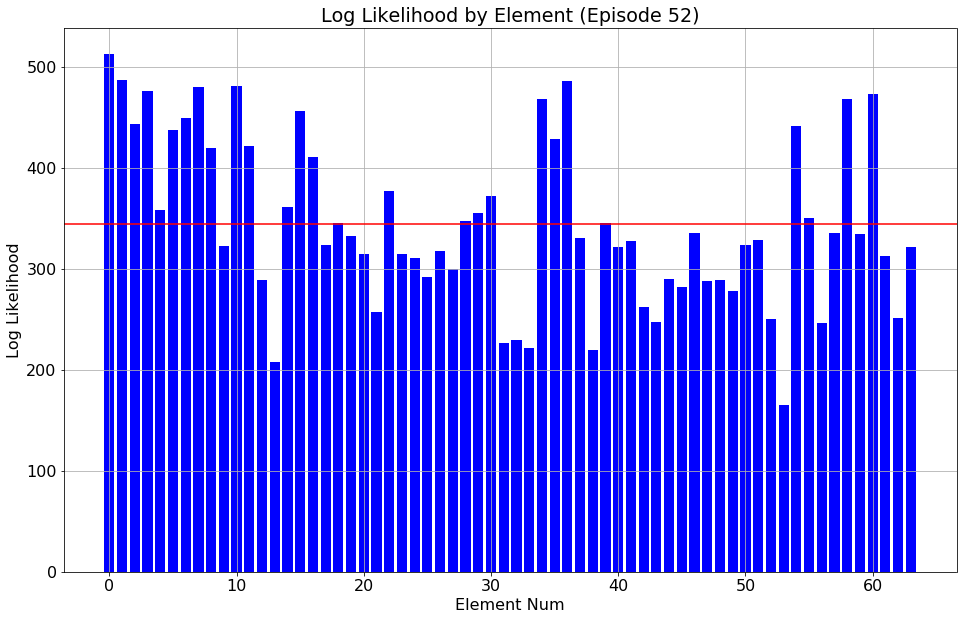

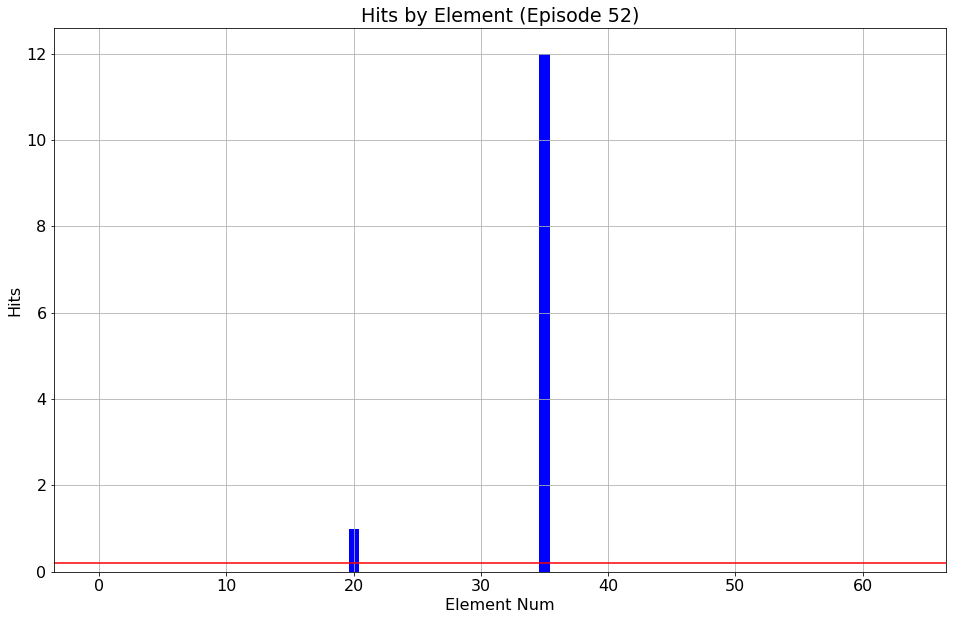


********************************************************************************
Round 12: 1600 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 52: Epoch  208, Batch  10400
effective_learning_rate=7.224e-05, training_time 564 sec.
Train on 3200 samples
Epoch 209/212
3200/3200 [==============================] - 5s 2ms/sample - loss: -191526653.7600
Epoch 210/212
3200/3200 [==============================] - 3s 782us/sample - loss: -194252298.2400
Epoch 211/212
3200/3200 [==============================] - 3s 842us/sample - loss: -196157559.0400
Epoch 212/212
3200/3200 [==============================] - 2s 767us/sample - loss: -198038196.1600
Adjusted element weight down on 13 candidate elements. Mean weight = 7.44e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    824.94 :   870.47 :    27.95 arc secon

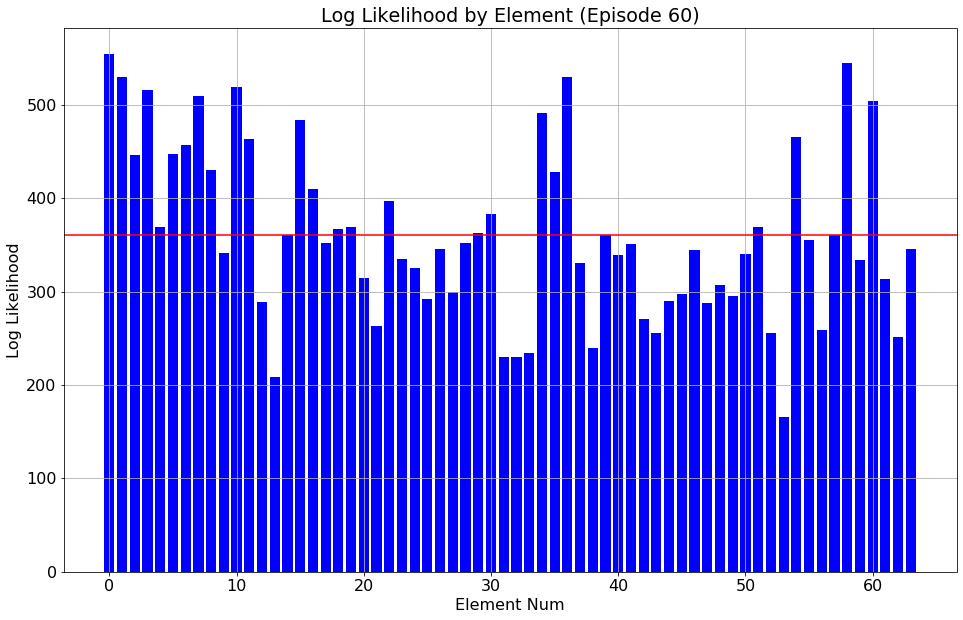

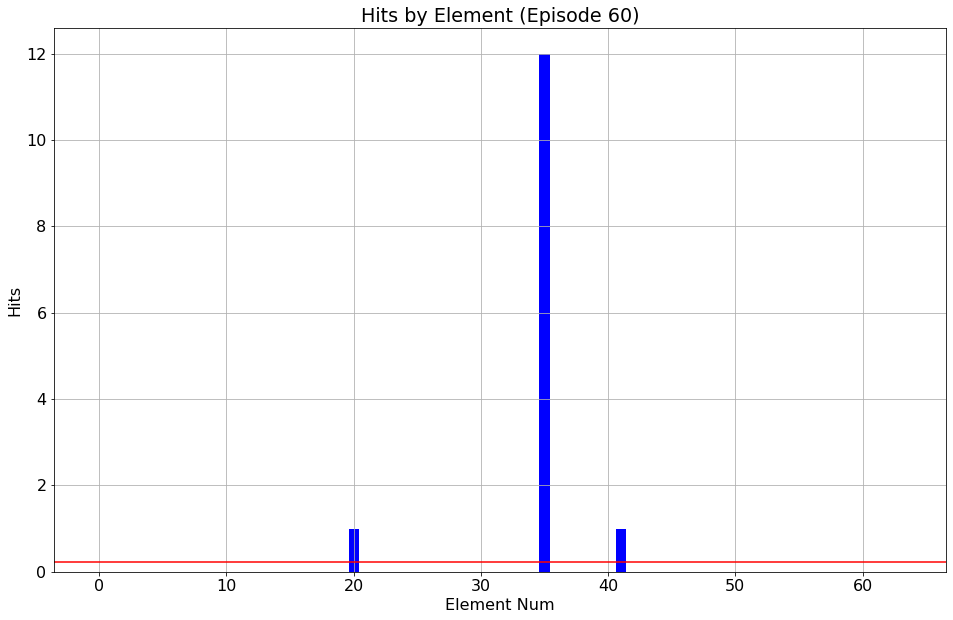


Training episode 60: Epoch  240, Batch  12000
effective_learning_rate=2.441e-04, training_time 661 sec.
Train on 3200 samples
Epoch 241/244
3200/3200 [==============================] - 4s 1ms/sample - loss: -942218611.2000
Epoch 242/244
3200/3200 [==============================] - 2s 680us/sample - loss: -977034625.2800
Epoch 243/244
3200/3200 [==============================] - 2s 649us/sample - loss: -1010311156.4800
Epoch 244/244
3200/3200 [==============================] - 2s 680us/sample - loss: -1041293861.1200
Adjusted element weight down on 62 candidate elements. Mean weight = 5.16e-01
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    193.94 :   200.00 :    27.95 arc seconds
Geom Mean Threshold :    400.00 :   400.00 :   400.00 arc seconds
Mean Log Likelihood :     60.32 :    54.58 :   422.33
Mean Hits           :      0.28 :     0.10 :    11.99
Good Elements       :      1.00

Training episode 61: Epoch  244, Batch  12200
effective_learning_ra

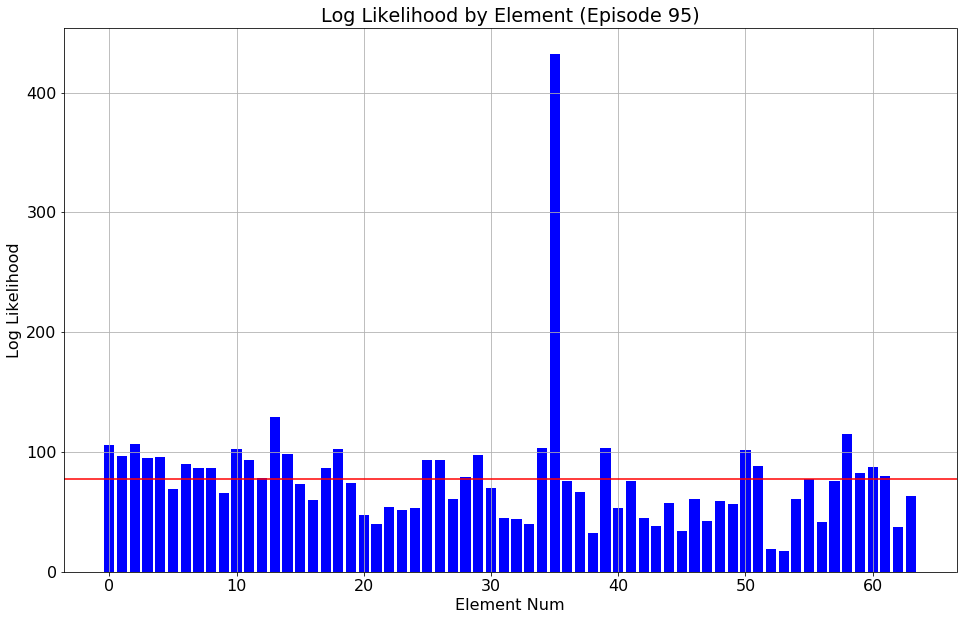

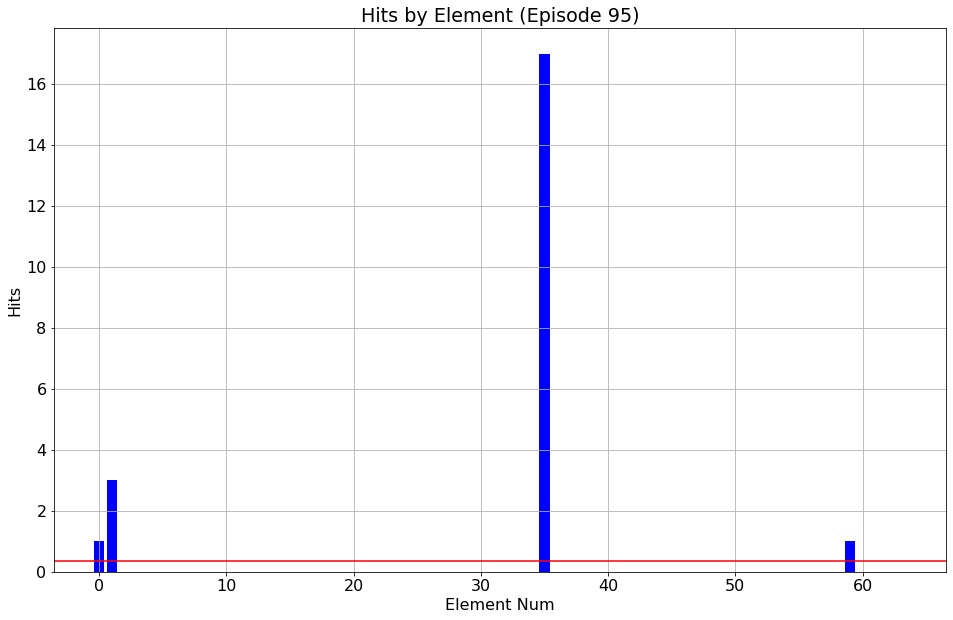

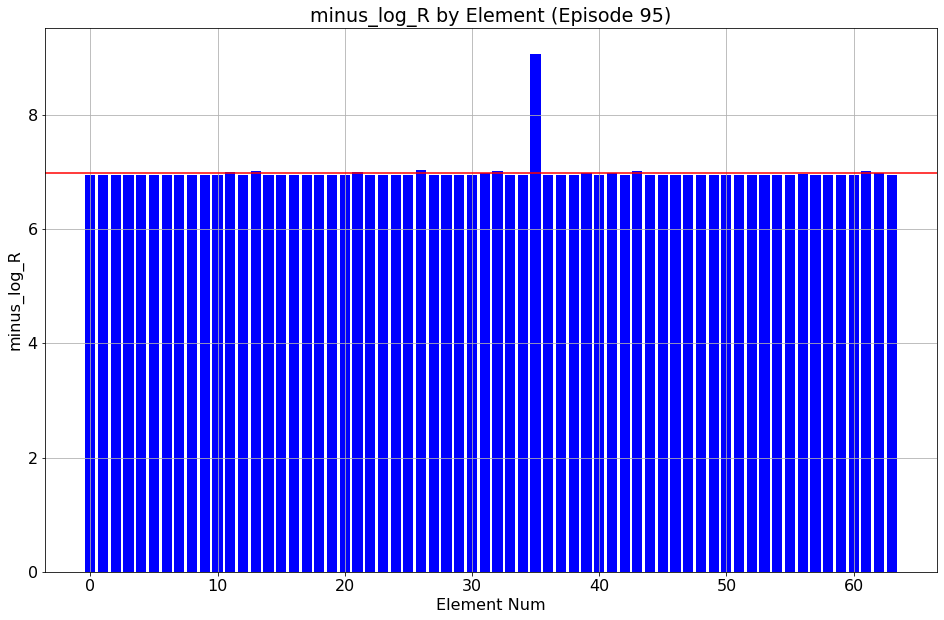

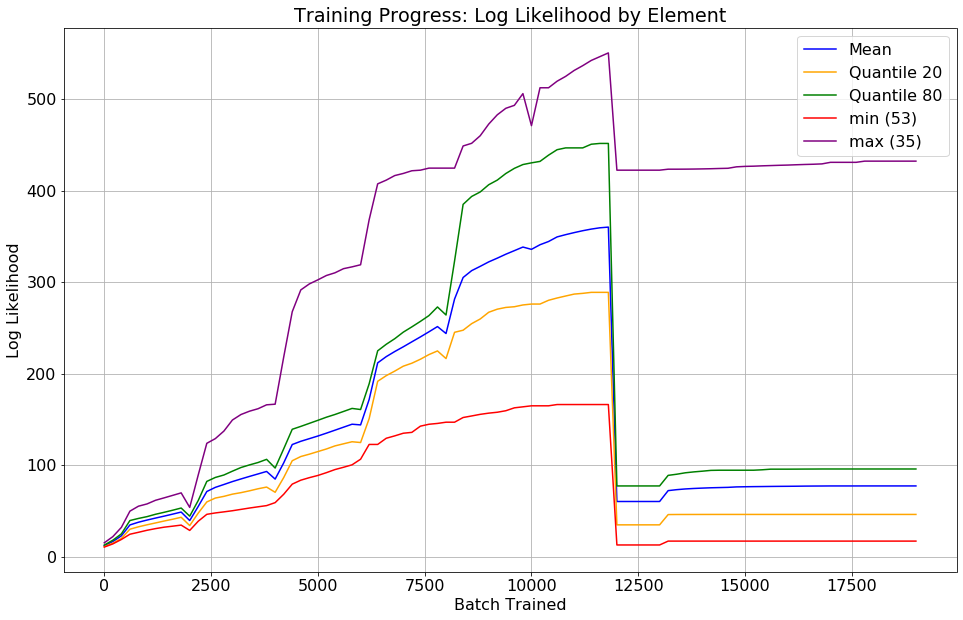

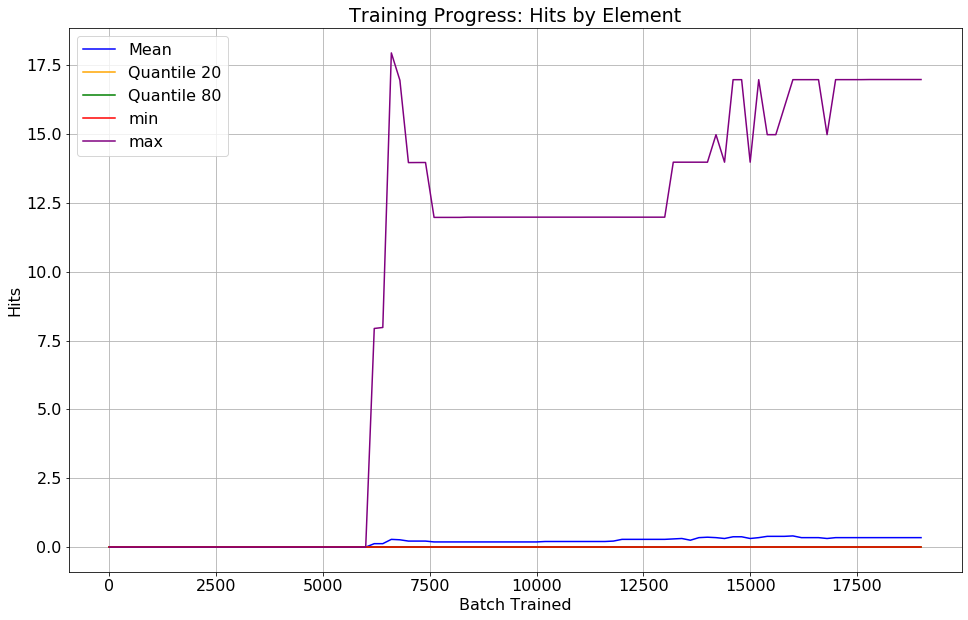

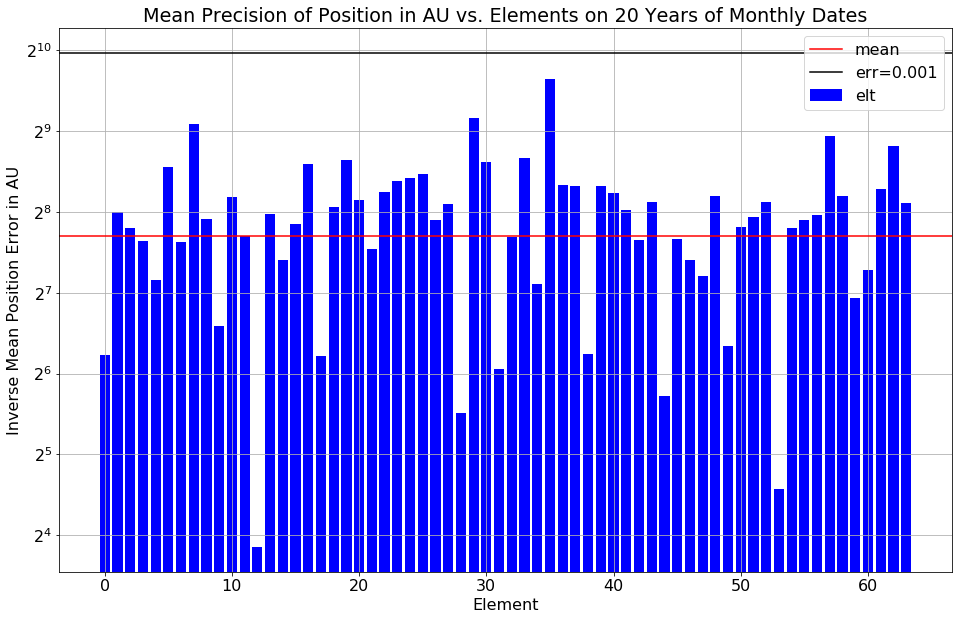

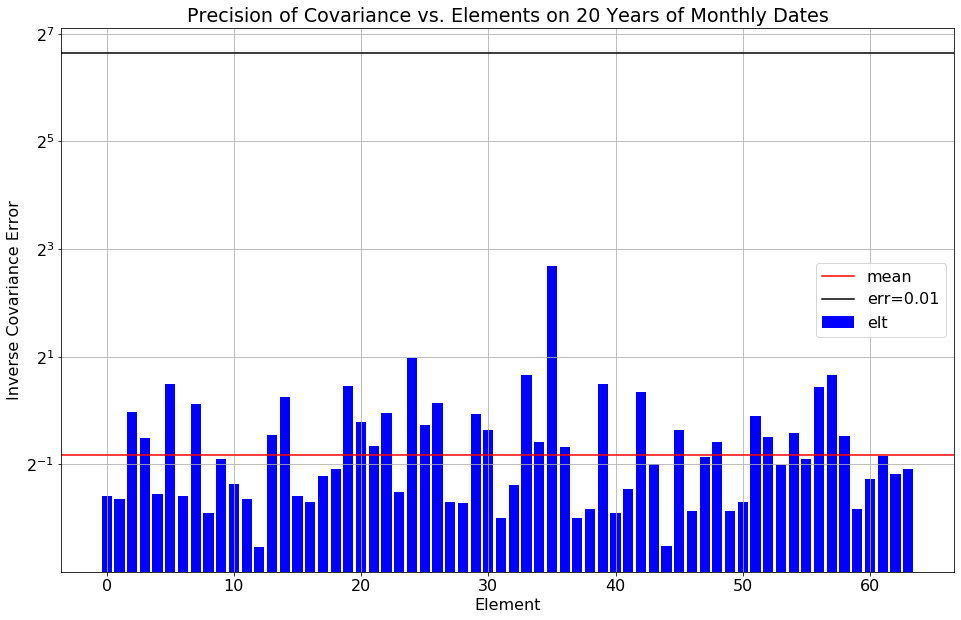

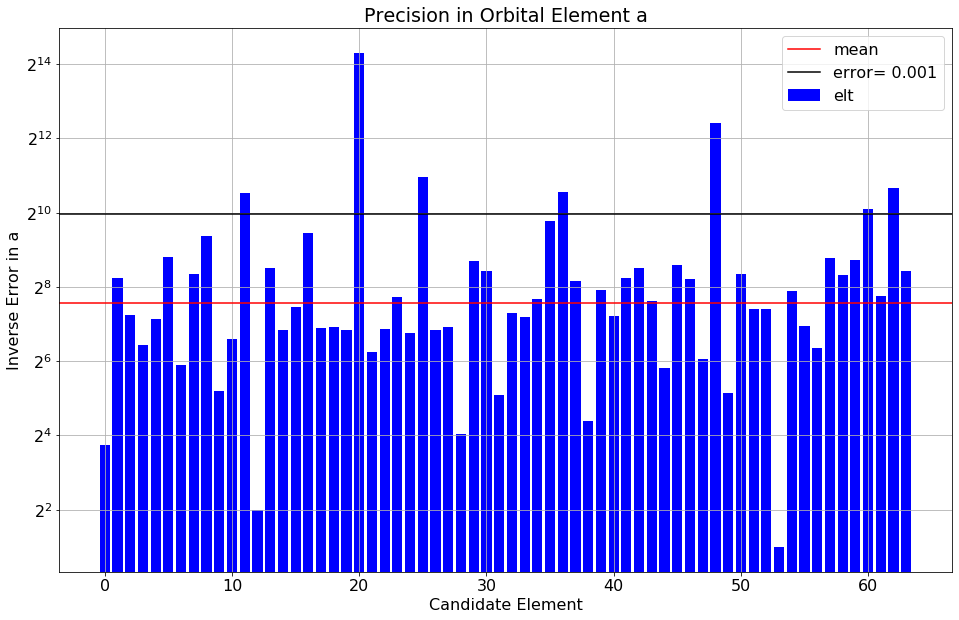

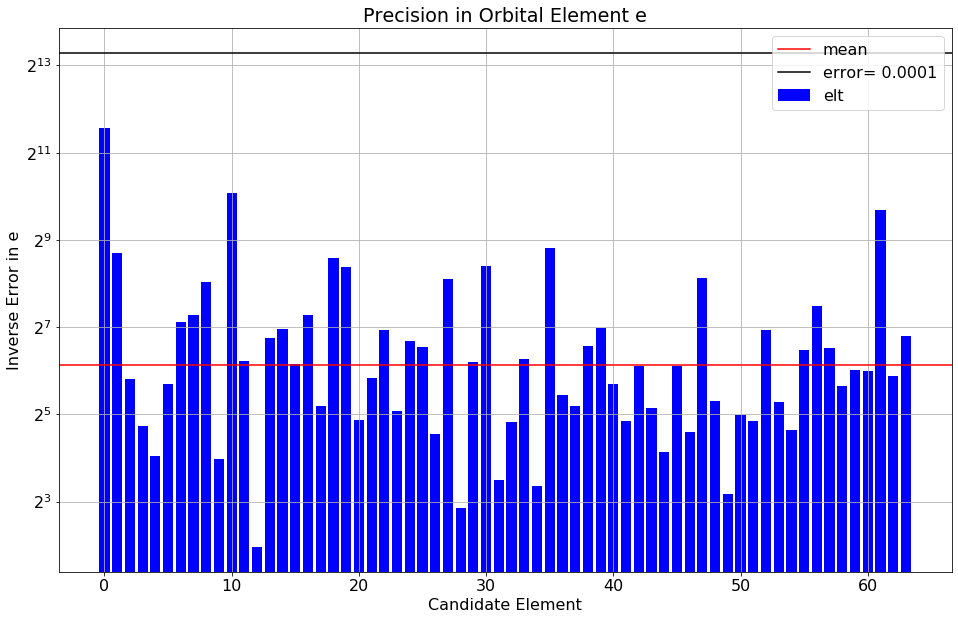

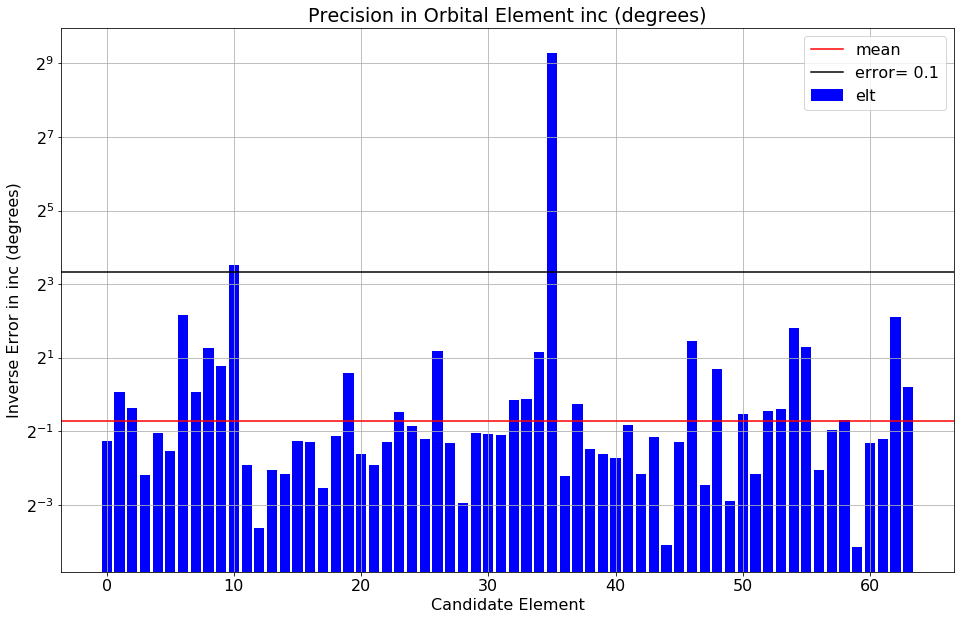

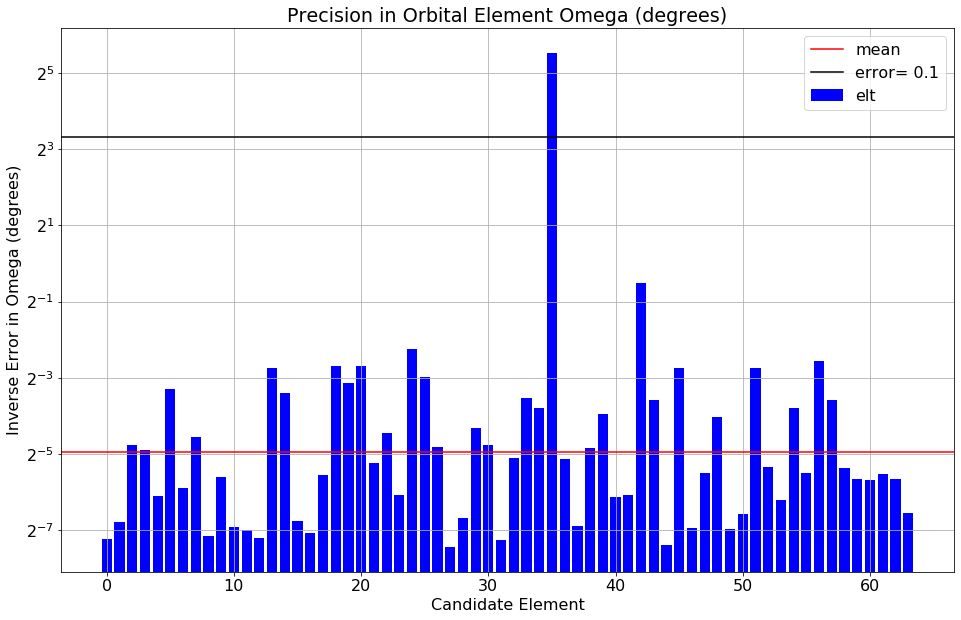

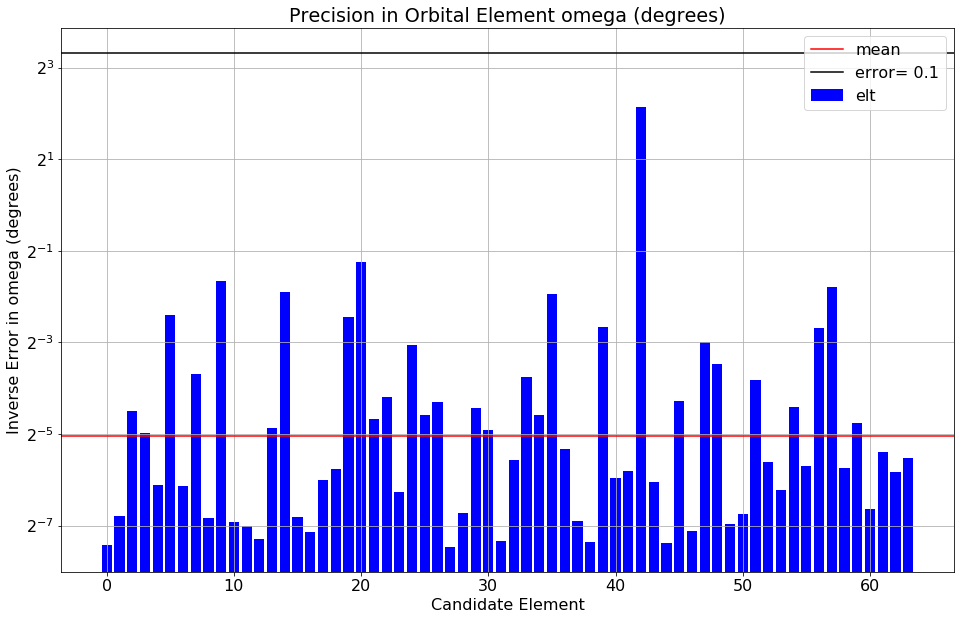

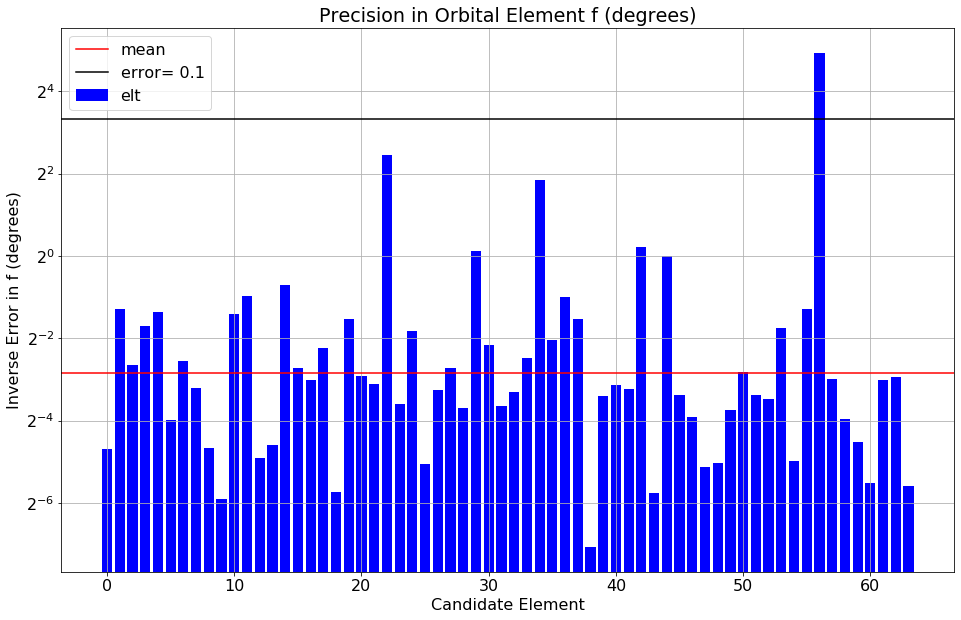

In [25]:
model.sieve(nearest_ast=True)

## Review Results Graphically

In [26]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [27]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [28]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [29]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [30]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [31]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [32]:
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,3.398713,0.186331,0.063334,0.642723,0.897038,-1.211743,58600.0,477.978027,0.000970,...,0.107230,386.028015,105.989799,1.0,93.0,15.007318,6.297532,208517,0.013306,2.994225
1,1,2.763764,0.163782,0.067214,1.364063,6.076426,-0.538475,58600.0,465.516907,0.000970,...,0.107798,388.074341,96.307083,3.0,76.0,16.249924,6.261846,419988,0.003901,3.142269
2,2,2.938612,0.099689,0.045787,3.941038,0.697394,1.890304,58600.0,423.929901,0.000970,...,0.109842,395.432007,106.764381,0.0,104.0,15.606993,5.803610,269511,0.004482,1.022579
3,3,2.825562,0.150439,0.016867,1.691272,5.346101,-0.087300,58600.0,452.021362,0.000970,...,0.110165,396.594574,95.201462,0.0,97.0,14.856440,6.061424,1064041,0.005032,1.431717
4,4,2.877507,0.179865,0.076847,0.231249,4.232769,2.437649,58600.0,321.317566,0.000970,...,0.104238,375.257721,95.519112,0.0,86.0,14.021422,6.117829,491486,0.006998,2.934977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.862201,0.083751,0.039356,0.748285,3.182059,3.076305,58600.0,321.802856,0.000970,...,0.108754,391.515930,82.299026,1.0,81.0,17.900579,5.572997,1175966,0.008151,3.540972
60,60,3.392285,0.027931,0.042366,5.334726,0.849678,0.854782,58600.0,434.548401,0.000970,...,0.111111,399.999939,87.756721,0.0,93.0,14.447312,5.999810,3622,0.006406,2.420153
61,61,2.515371,0.118657,0.067341,4.665432,1.931371,-1.064792,58600.0,292.010437,0.000895,...,0.104787,377.232635,80.318024,0.0,56.0,16.260872,5.941454,356564,0.003224,1.790766
62,62,2.322798,0.195031,0.048943,3.344346,2.207182,-0.653680,58600.0,242.390030,0.000933,...,0.106267,382.560608,37.080860,0.0,27.0,17.442160,5.938266,187111,0.002219,2.258869


In [34]:
# Review asteroids nearest to the fitted elements
# cols = ['element_id', 'nearest_ast_num', 'nearest_ast_name', 'nearest_ast_dist', 'nearest_ast_q_norm']
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
is_close_cart = (model.elts_near_ast.nearest_ast_dist < 5.0E-3)
is_close_cov = (model.elts_near_ast.nearest_ast_q_norm < 1.0)
has_hits = (model.elts_fit.hits >= 10)
# is_converged = is_close_cart & is_close_cov
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits)
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm: {err_cov_mean:5.2e}')

Good convergence on 1 asteroids.
Mean on converged asteroids:
Number of hits         :  0.34
Mean Distance in AU    : 1.25e-03
GeoMean Distance in AU : 1.25e-03
Covariance norm: 1.56e-01


In [35]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
35,35,432.191833,16.98604,23.958437,364.550385,49846,0.001254,0.156325


In [36]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [37]:
# model.elts_near_ast

In [38]:
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,3.398713,0.186331,0.063334,0.642723,0.897038,-1.211743,58600.0,477.978027,0.000970,...,0.107230,386.028015,105.989799,1.0,93.0,15.007318,6.297532,208517,0.013306,2.994225
1,1,2.763764,0.163782,0.067214,1.364063,6.076426,-0.538475,58600.0,465.516907,0.000970,...,0.107798,388.074341,96.307083,3.0,76.0,16.249924,6.261846,419988,0.003901,3.142269
2,2,2.938612,0.099689,0.045787,3.941038,0.697394,1.890304,58600.0,423.929901,0.000970,...,0.109842,395.432007,106.764381,0.0,104.0,15.606993,5.803610,269511,0.004482,1.022579
3,3,2.825562,0.150439,0.016867,1.691272,5.346101,-0.087300,58600.0,452.021362,0.000970,...,0.110165,396.594574,95.201462,0.0,97.0,14.856440,6.061424,1064041,0.005032,1.431717
4,4,2.877507,0.179865,0.076847,0.231249,4.232769,2.437649,58600.0,321.317566,0.000970,...,0.104238,375.257721,95.519112,0.0,86.0,14.021422,6.117829,491486,0.006998,2.934977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.862201,0.083751,0.039356,0.748285,3.182059,3.076305,58600.0,321.802856,0.000970,...,0.108754,391.515930,82.299026,1.0,81.0,17.900579,5.572997,1175966,0.008151,3.540972
60,60,3.392285,0.027931,0.042366,5.334726,0.849678,0.854782,58600.0,434.548401,0.000970,...,0.111111,399.999939,87.756721,0.0,93.0,14.447312,5.999810,3622,0.006406,2.420153
61,61,2.515371,0.118657,0.067341,4.665432,1.931371,-1.064792,58600.0,292.010437,0.000895,...,0.104787,377.232635,80.318024,0.0,56.0,16.260872,5.941454,356564,0.003224,1.790766
62,62,2.322798,0.195031,0.048943,3.344346,2.207182,-0.653680,58600.0,242.390030,0.000933,...,0.106267,382.560608,37.080860,0.0,27.0,17.442160,5.938266,187111,0.002219,2.258869


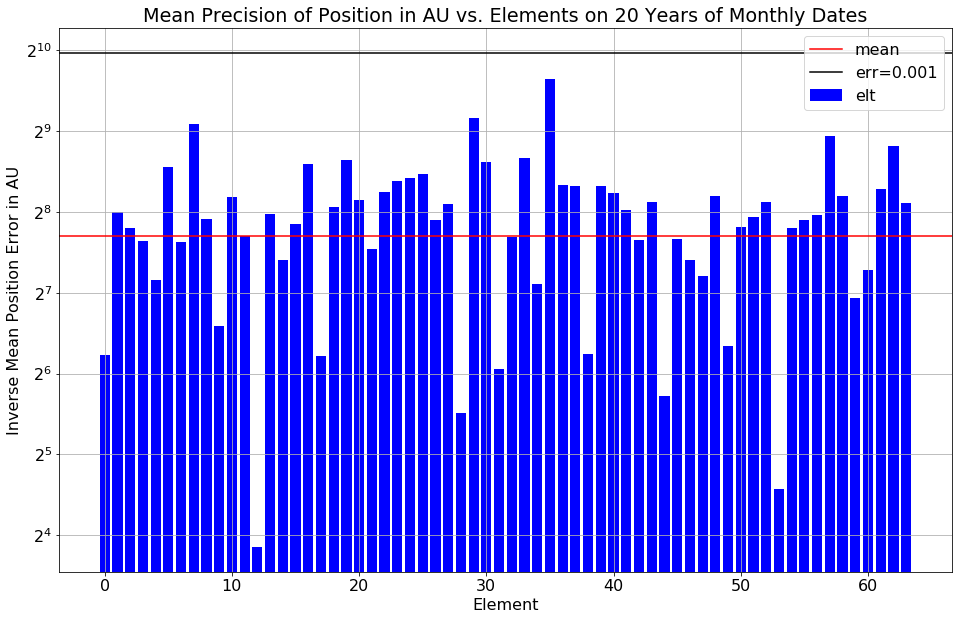

In [39]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

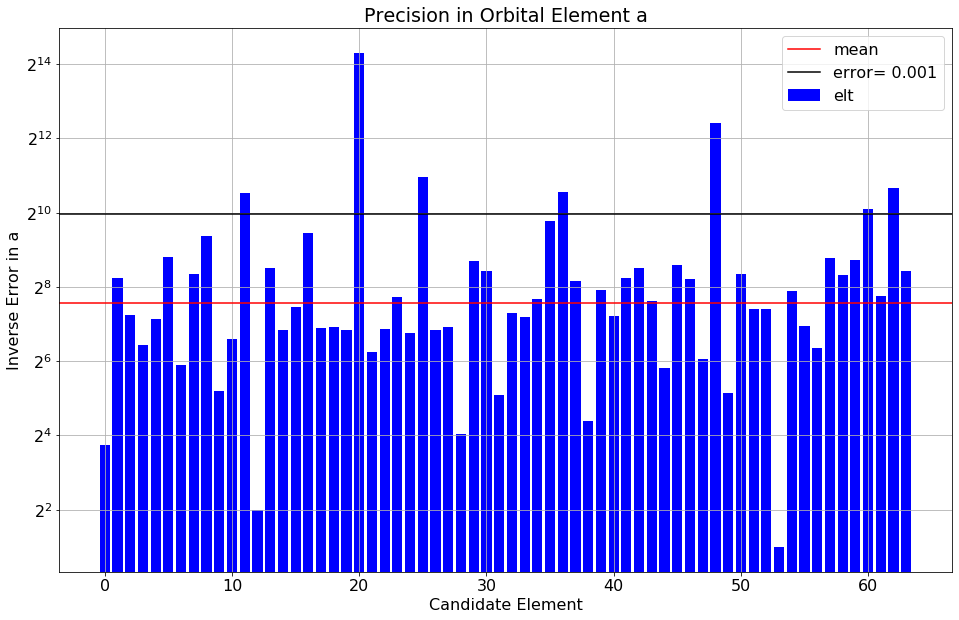

In [40]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

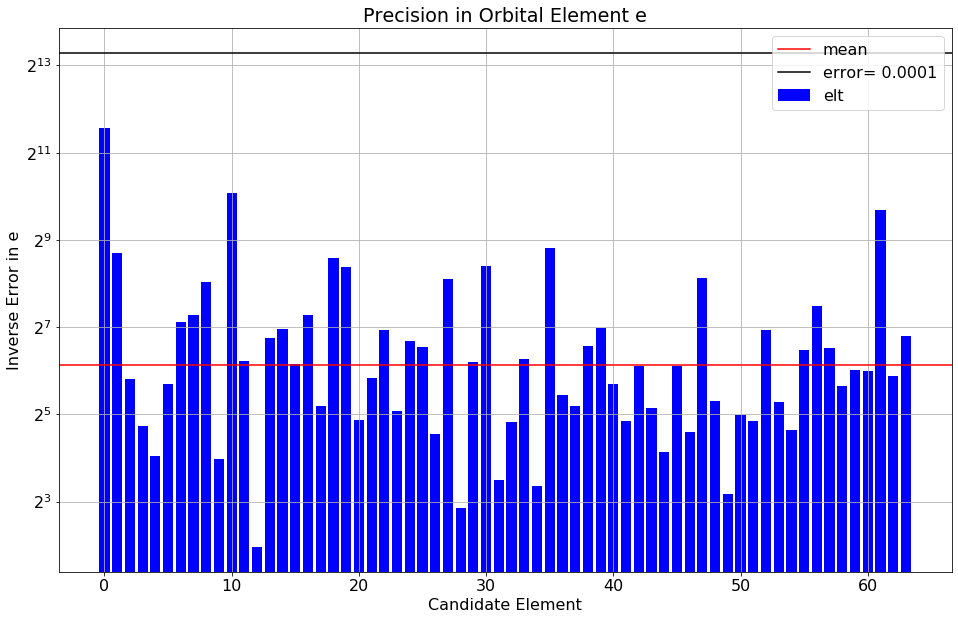

In [41]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)